In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('vader_lexicon')

import warnings
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
data = pd.read_csv('../../data/data.csv')

In [4]:
# import os
# os.sys.path.append(os.path.dirname(os.path.abspath('..')))
# import lol.f

## How should I speak to my audience?

The title of a video allows people to search for it. Aside from the thumbnail of the video, it is the only piece of information that tells potential viewers what they will be watching. Therefore, it is important to get the tone right. Speaking to your audience in a misaligned tone can mean the difference between trending and receiving little to no views.

We can evaluate the compound sentiment of a YouTube video title. This tells us how positive or negative the sentiment of the sentence is. Averaging the sentiment over all videos in a single category yields a key insight into the different kinds of audiences.

In [187]:
sentiment_analyser = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    return sentiment_analyser.polarity_scores(sentence)['compound']

In [189]:
sentiment = data['title'].apply(get_sentiment)

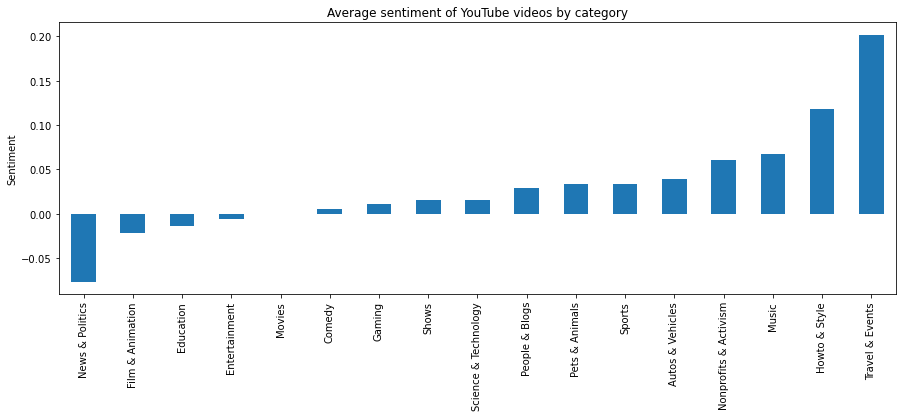

In [205]:
plt.figure(figsize=(15,5))

pd.concat(
    [data[['category_name','video_id']], sentiment], axis=1
).groupby('video_id').first().groupby('category_name').mean()['title'].sort_values().plot.bar()

plt.xlabel('')
plt.ylabel('Sentiment')
plt.title('Average sentiment of YouTube videos by category')
plt.show()

Travel & Events video titles are the most positive whereas News & Politics are the most negative. It is clear that audiences of newsworthy and politicical videos are more inclined to click videos which convey negative sentiment, while viewers of travelling channels are more likely to want uplifting and optimistic content. In turn, YouTubers need to learn to cater to these audiences and therefore adjust the perceived sentiment of their titles (and content) accordingly.

## How long should my title be?

In [212]:
lengths = data['title'].apply(lambda s: len(word_tokenize(s)))

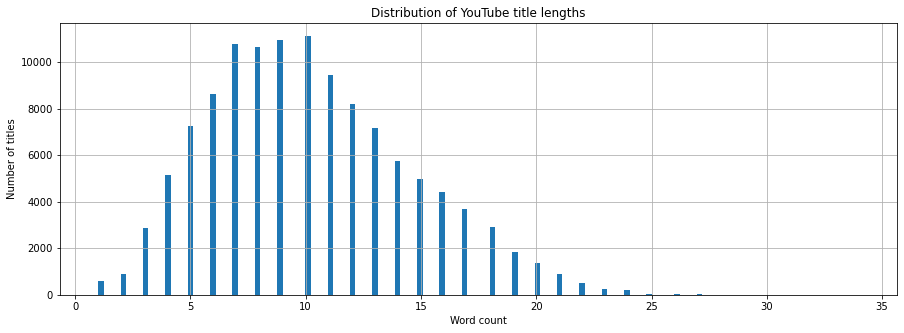

In [221]:
plt.figure(figsize=(15,5))
lengths.hist(bins='auto')
plt.title('Distribution of YouTube title lengths')
plt.xlabel('Word count')
plt.ylabel('Number of titles')
plt.show()

It seems that the modal sentence length amongst trending videos is around $10$ words with significantly longer and shorter titles not trending well. This is likely because it is long enough to convey information while being short enough to be readable. 

### Pre-processing

In [28]:
recency_data = data[data['country'] == 'gb']

# total time spent on trending
recency_data = recency_data.merge(
    recency_data.groupby('video_id').count()[['category_name']].rename({'category_name' : 'time_on_trend'}, axis=1).reset_index(), 
    on='video_id',
)

recency_data_trend = pd.to_datetime(
    recency_data.groupby('video_id').first()['trending_date'], errors='coerce', format='%y.%d.%m'
)

recency_data_publish = pd.to_datetime(
    recency_data.groupby('video_id').first()['publish_time']
)

# total time to reach trending
recency_data = recency_data.merge(
    pd.DataFrame((recency_data_trend.dt.date - recency_data_publish.dt.date).dt.days + 1).rename(
        {0:'time_to_trend'}, axis=1
    ).reset_index(),
    on='video_id',
)

In [186]:
# Lagged averaged variable for all videos
def lag_gen_op(variable, op='mean', num_days=4):
    return pd.concat([
        recency_data.groupby('trending_date').agg({variable: op}).shift(j).rename(
            columns={variable:'gen-{}-{}-{}'.format(variable,op,j)}
        ) for j in range(1,num_days + 1)
    ], axis=1).reset_index()

# Lagged average variable for all videos per category.
def lag_cat_op(variable, op='mean', num_days=4):
    return pd.concat([
        recency_data.groupby(['trending_date', 'category_id']).agg({variable : op}).groupby(level=1).shift(j).rename(
            columns={variable : 'cat-{}-{}-{}'.format(variable,op,j)}
        ) for j in range(1,num_days + 1)
    ], axis=1).reset_index()

## My video is trending. How long will it stay there?

For YouTubers whose videos have landed on the trending list, the goal is for it to stay there as long as possible. This will maximise exposure and ensure that their video (and corresponding YouTube channel) remains popular.  To aid them in this pursuit, we have built a model that predicts the number of days that a video will spend on YouTube's trending list. 

Since the past determines the future, we considered the average time that videos have trended for in the $5$ days previous to the release of the new video. We also considered the same statistic but restricted to videos in the same category as that of the video of interest. It is also natural to consider the time it has taken for videos in the past to appear on YouTube's trending list as this indicates how viral they were. Other factors including average likes amongst trending videos are also factored in. Lastly, we include statistics on the video itself, such as the number of likes it has.

In [174]:
# introduce lagged variables

ii = recency_data.merge(
    lag_gen_op('time_to_trend', num_days=4), on='trending_date'
).merge(
    lag_cat_op('time_to_trend', num_days=4), on=['trending_date', 'category_id']
).merge(
    lag_gen_op('time_on_trend', num_days=4), on='trending_date'
).merge(
    lag_cat_op('time_on_trend', num_days=4), on=['trending_date', 'category_id']
).merge(
    lag_cat_op('likes', num_days=5), on=['trending_date', 'category_id']
)

# include video statistics

ii = ii.groupby('video_id').first().filter(
    regex='^(gen-.+|cat-.+|time_to_trend|time_on_trend|likes|views|comment_count|dislikes)$'
).dropna()

In [175]:
X, y = ii.drop('time_on_trend', axis=1).values, ii[['time_on_trend']].values

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

We validate our model and achieve a statistically significant score. This is a vast improvement on only restricting oneself to using statistics on the YouTube video of interest. This is because YouTube is an open marketplace where the behaviours of different trending videos affect each other.

In [178]:
rf.score(X_test, y_test)

0.3760426848384959

Our analysis has a mean absolute error of around 5 days.

In [179]:
mean_absolute_error(y_test, rf.predict(X_test))

4.8776190476190475

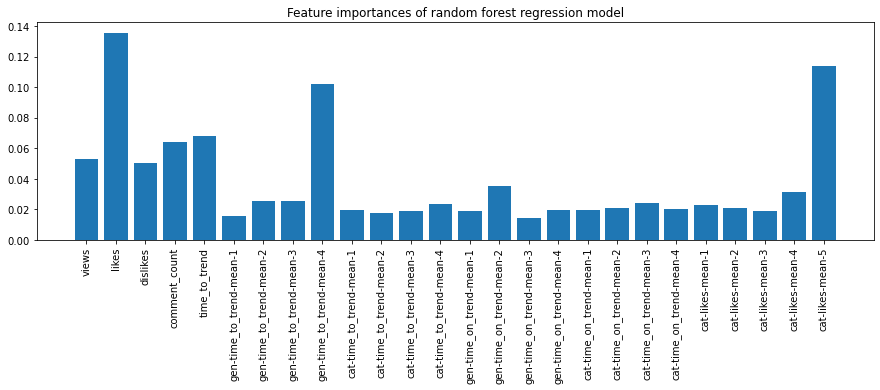

In [184]:
plt.figure(figsize=(15,4))
plt.bar(ii.drop('time_on_trend', axis=1).columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances of random forest regression model')
plt.show()

From this, we draw several conclusions:

- The number of likes that a video has when it reaches the trending list contributes the most to how long it will trend for. Practically, this means that YouTubers should try to keep their audience happy. Being controversial is only a viable strategy if there is audience that rewards you for it. Historic likes in the video category are also a good predictor of this.
- The average time that it takes for videos (either in general or in the category of interest) to trend a few days before the video of interest trends plays a great role. Practically, this allows one to time the release of a YouTube video so as to maximise the time spent trending.

It is now straightforward to improve the model by removing features with little importance.

## Will my video trend tomorrow given that it has today?

From research, we know that YouTube statistics exhibit long range memory. This means that it should be straightforward to predict whether a video will remain trending tomorrow given that it has trended today. This fact is of great importance to YouTubers whose advertising and video release schedule revolves around the popularity of their videos. If a video is predicted to leave its trending status, a strategy can be preemptively developed moving forwards.

In [138]:
i = recency_data

In [139]:
i = i.merge(
    i.groupby('video_id').last()['trending_date'].reset_index().rename(columns={'trending_date':'final_date'}), 
    on = 'video_id'
)

In [140]:
i['trend_tomorrow'] = i['trending_date'] != i['final_date']

In [141]:
i = i.merge(
    lag_gen_op('time_to_trend', num_days=4), on='trending_date'
).merge(
    lag_cat_op('time_to_trend', num_days=4), on=['trending_date', 'category_id']
).merge(
    lag_gen_op('time_on_trend', num_days=4), on='trending_date'
).merge(
    lag_cat_op('time_on_trend', num_days=4), on=['trending_date', 'category_id']
).merge(
    lag_cat_op('likes', num_days=5), on=['trending_date', 'category_id']
)

In [142]:
i = i.groupby('video_id').first().filter(
    regex='^(gen-.+|cat-.+|time_to_trend|trend_tomorrow|likes|views|comment_count|dislikes)$'
).dropna()

In [143]:
X, y = i.drop('trend_tomorrow', axis=1).values, i[['trend_tomorrow']].values

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [145]:
rf = RandomForestClassifier()

In [146]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [147]:
rf.score(X_test, y_test)

0.9272789347900308

In [148]:
sum((rf.predict(X_test) ^ y_test)[0])

27

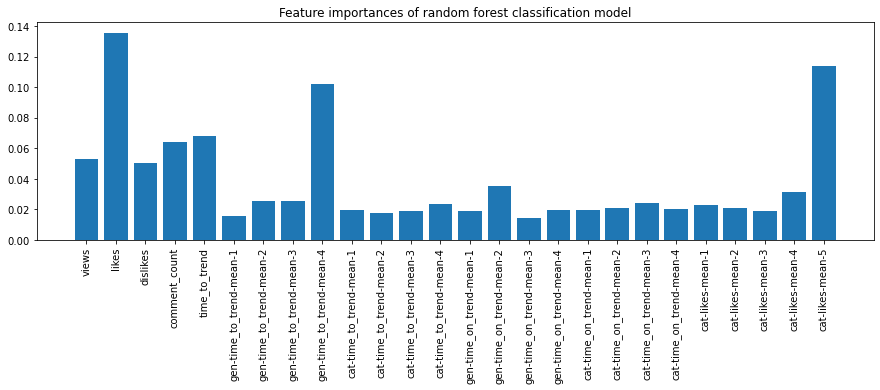

In [183]:
plt.figure(figsize=(15,4))
plt.bar(i.drop('trend_tomorrow', axis=1).columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances of random forest classification model')
plt.show()

In [150]:
i['trend_tomorrow'].value_counts()

True     3027
False     227
Name: trend_tomorrow, dtype: int64

In [151]:
pd.Series(y_test.T[0]).value_counts()

True     2729
False     200
dtype: int64

Shortcomings class imbalance...